# Part 2: Beijing Air Quality
## About
<p align='justify'>We are going to use Beijing PM2.5 Data which we can fing available <a href=https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data>hee</a>. This hourly dataset contains the PM2.5 data (readings of various air quality measures) of US Embassy in Beijing over a span of five years (2010-2014). Mereoligical data from Beijing Capital International Airport is also included. It contains 43824 samples and 13 variables. We are going to attempt to predict the quality of the air (PM2.5) 100 days into the future</p>
<details><summary>Variables</summary>

<ul>
<li><b>No:</b> row number
<li><b>year:</b> year of data in this row
<li><b>month:</b> month of data in this row
<li><b>day:</b> day of data in this row
<li><b>hour:</b> hour of data in this row
<li><b>pm2.5:</b> PM2.5 concentration,
<li><b>DEWP:</b> Dew Point
<li><b>TEMP:</b> Temperature
<li><b>PRES:</b> Pressure
<li><b>cbwd:</b> Combined wind direction
<li><b>lws:</b> Cumulated wind speed
<li><b>ls:</b> Cumulated hours of snow
<li><b>ls:</b> Cumulated hours of rain
</ul>

</details>

## Moules

In [295]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
import statsmodels.api as sm
import scipy.stats as st
import nbformat

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM
from math import sqrt


## Load data

In [40]:
file_path = os.path.join(os.getcwd(), '../data/us_ambassy/PRSA_data_2010.1.1-2014.12.31.csv')
df = pd.read_csv(file_path)

## EDA

In [41]:
# 'No' variable can be dropped
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [42]:
df.shape

(43824, 13)

In [43]:
# There seems to be null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [44]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


We can see the pressence of up to 2067 null values in the target variables

In [45]:
# There are missing values in the target variable
print(df.isnull().sum())
df.loc[df['pm2.5'].isnull()]

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43548,43549,2014,12,20,12,NaN,-18,0.0,1030.0,NW,244.97,0,0
43549,43550,2014,12,20,13,NaN,-19,1.0,1029.0,NW,249.89,0,0
43550,43551,2014,12,20,14,NaN,-20,1.0,1029.0,NW,257.04,0,0
43551,43552,2014,12,20,15,NaN,-20,2.0,1028.0,NW,262.85,0,0


Lets do a univariate analysis first of the target variable. At first sight we can't see any seasonality, if we zoom in at the first 10000 samples we can clearly see some of the missing data
we detected earlier

In [46]:
# Lets first look at the target variable time series, 
fig = go.Figure(data=go.Scatter(y=df['pm2.5']))
fig.update_layout(title='PM2.5 data', yaxis_title='Value')
fig.show()

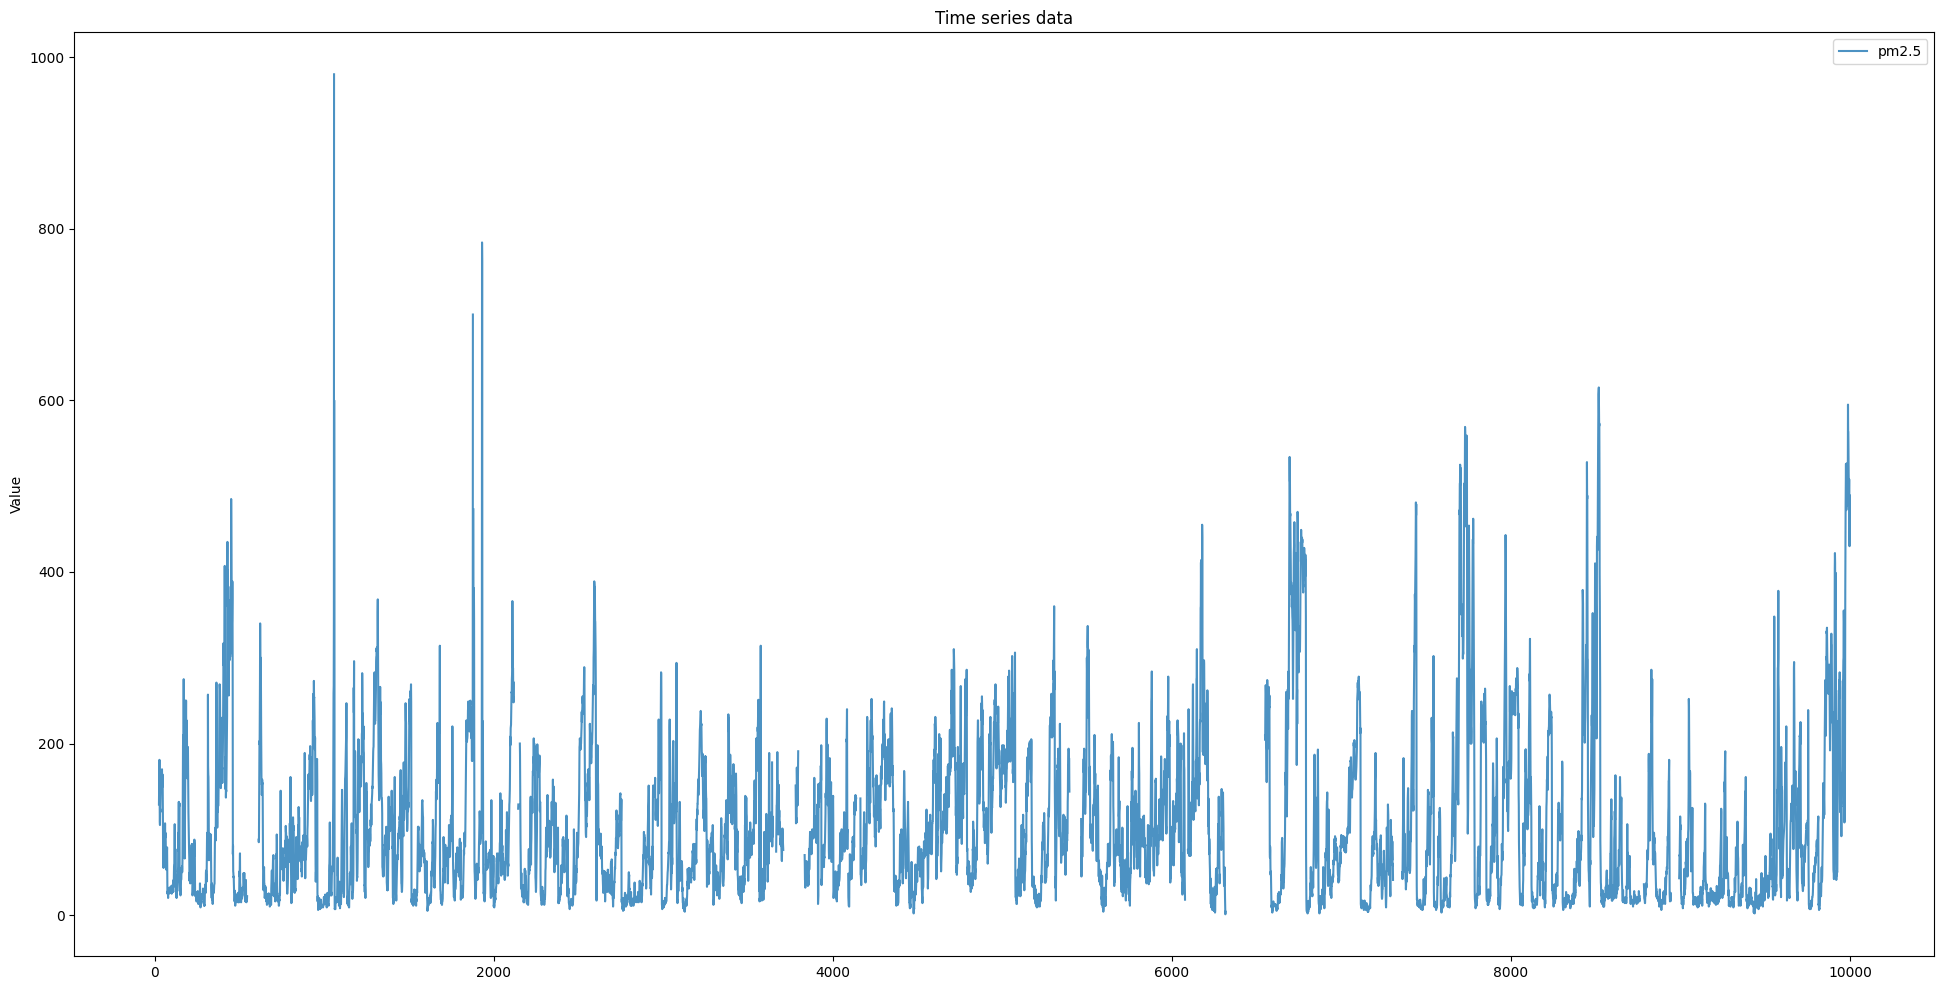

In [47]:
# Closer look at the first 10k samples
plt.figure(figsize=(24, 12))
plt.plot(df['pm2.5'][:10000], label='pm2.5', alpha=0.8)
plt.title('Time series data')
plt.ylabel('Value')
plt.legend()
plt.show()

Let's try interpolation

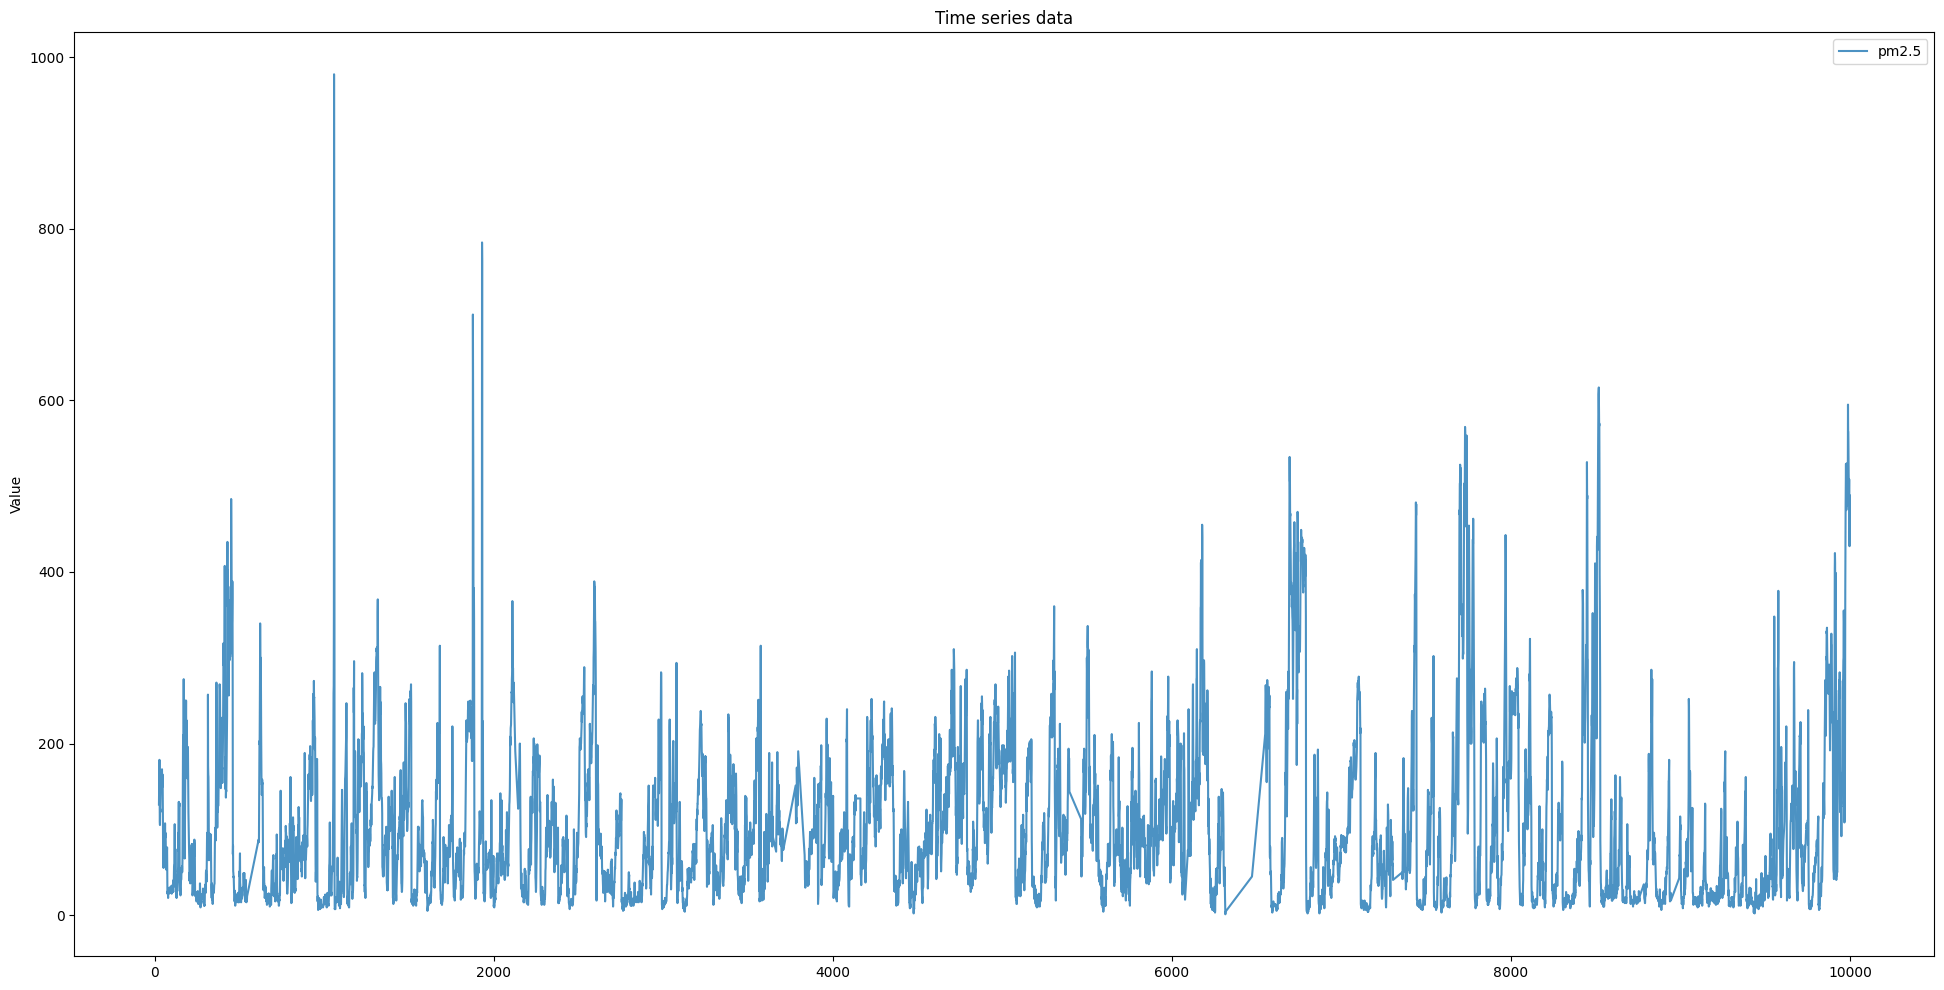

In [48]:
# Given the reduced amount of missing data, and that in most cases it is surrounded by non missing data, lets try interpolation
plt.figure(figsize=(24, 12))
plt.plot(df['pm2.5'].interpolate(method='linear')[:10000], label='pm2.5', alpha=0.8)
plt.title('Time series data')
plt.ylabel('Value')
plt.legend()
plt.show()

Lets see imputing with the median

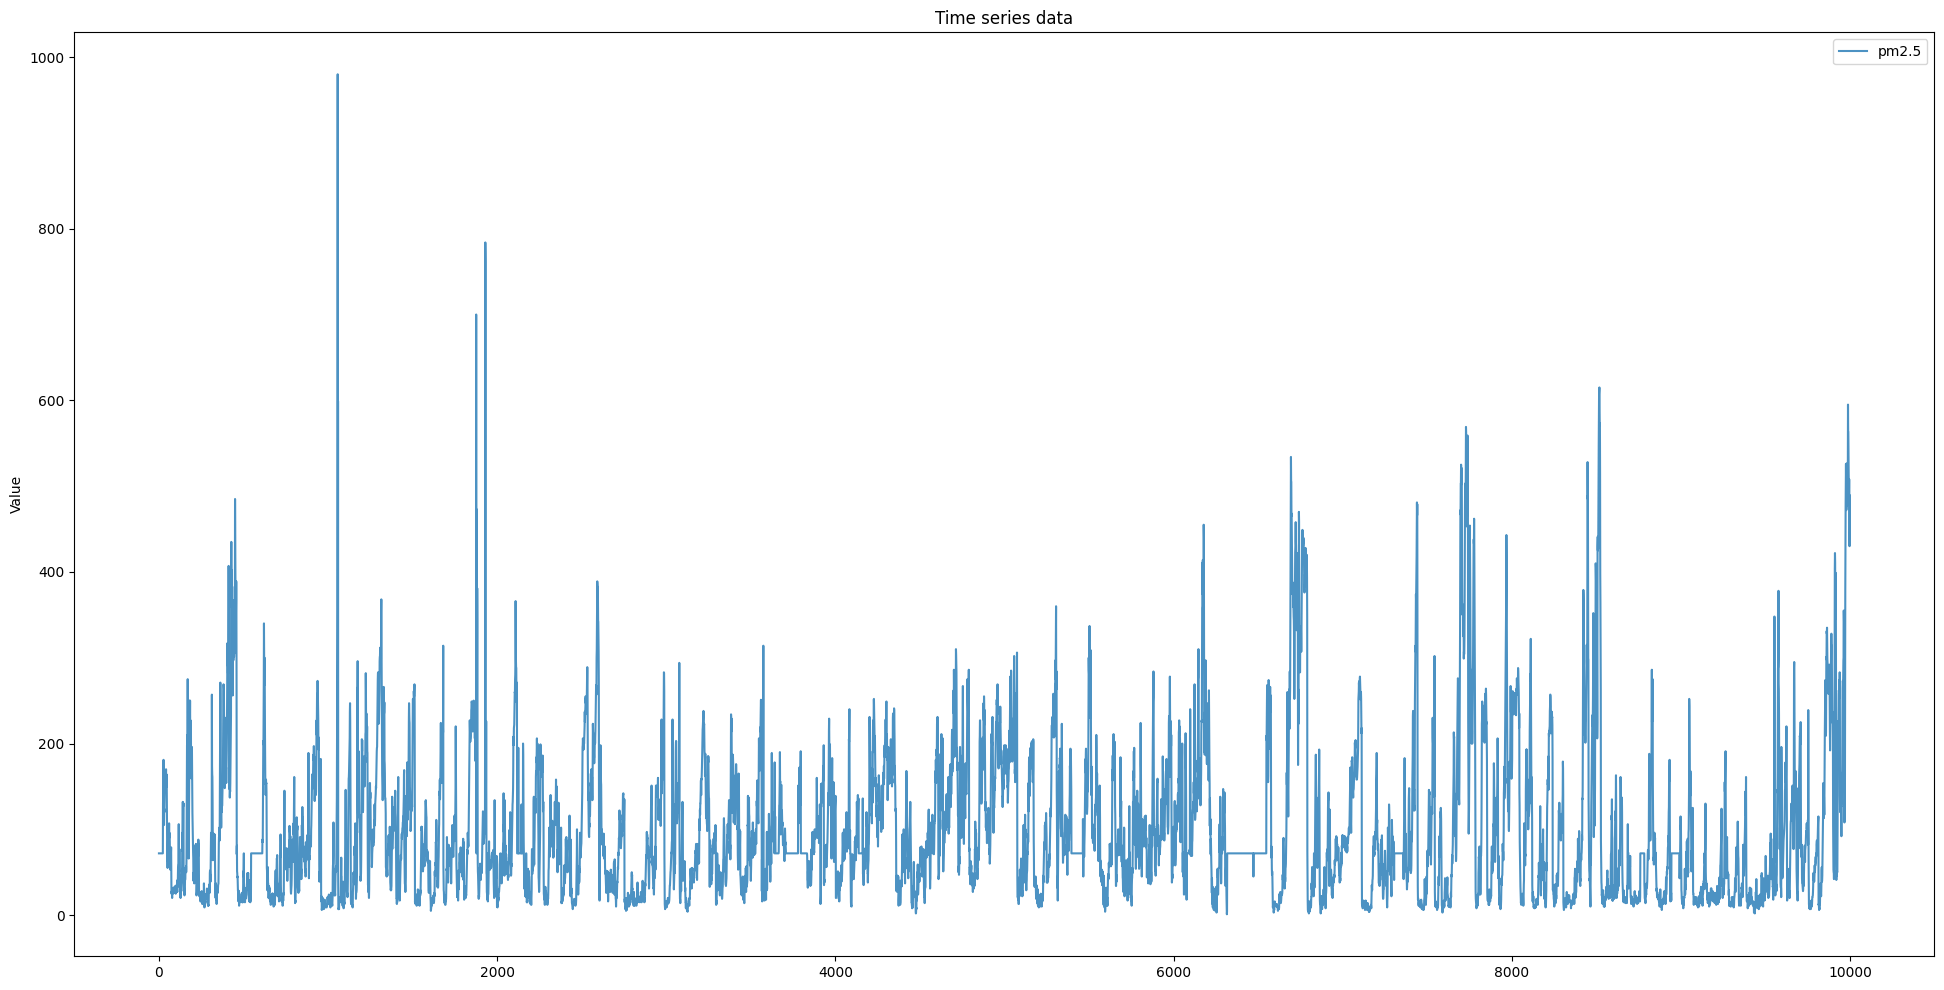

In [49]:
# Lets try the imputing by the median, but clearly interpolation is the better option, we could also try out LOCF or NOCB but in this case interpolation clearly appears to be the winner
plt.figure(figsize=(24, 12))
plt.plot(df['pm2.5'].fillna(df['pm2.5'].median())[:10000], label='pm2.5', alpha=0.8)
plt.title('Time series data')
plt.ylabel('Value')
plt.legend()
plt.show()

We decide to interpolate missing values but still detect 24 NaN which correspond to the beginning of the series (the first day). Being only 24 out of ~43k samples we are going to opt for removing them

In [50]:
# We interpolate the NaN but still see 24 which account to the beginning of the time series to the first day, at this point being only 24 out of 43k we are going to opt for dropping them
df['pm2.5'].interpolate(method='linear', inplace=True)
print(df.isnull().sum())
df.loc[df['pm2.5'].isnull()]

No        0
year      0
month     0
day       0
hour      0
pm2.5    24
DEWP      0
TEMP      0
PRES      0
cbwd      0
Iws       0
Is        0
Ir        0
dtype: int64


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
5,6,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
6,7,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0
7,8,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0
8,9,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0
9,10,2010,1,1,9,NaN,-20,-8.0,1017.0,NW,27.28,0,0


In [51]:
# Dropping
df = df.dropna(subset=['pm2.5'])
print('Remaining 24 NaN dropped')

Remaining 24 NaN dropped


In [54]:
# Encoding cbwd as category
print(df['cbwd'].unique())
df['cbwd'] = df['cbwd'].astype('category')

['SE', 'cv', 'NW', 'NE']
Categories (4, object): ['NE', 'NW', 'SE', 'cv']


Lets group the time columns in one and convert to date time to use as index.

In [59]:
# Lets convert to time variables to date time and add as index
df_eda = df.copy()
df_eda['dateString']=df['year'].astype(str) + df['month'].astype(str).str.zfill(2)+ df['day'].astype(str).str.zfill(2)
df_eda['Date'] = pd.to_datetime(df['dateString'], format='%Y%m%d')

df_eda.set_index('Date', inplace=True)
df_eda.drop(labels=['No', 'Date', 'dateString'], axis=1, inplace=True, errors='ignore')
df_eda.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
Date,,,,,,,,,,,,
2010-01-02,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


* The series shows hgih variability in time with non regular growing and decreasing phases in the long term (yearly).
* These phases don't seem to have a fixed frequency (like one month every year), so it indicates we may be able to rule out seasonality
* It is also hard to observe any distinguishable trend
* Its max value its reached at the end of january in 2013
* Its min value its curiously reached around the same day in 2011
* Since we have excluded seasonal and trend components, it seems to indicate the series its stationary

In [61]:
df_eda.drop(labels=['cbwd'], axis=1, inplace=True, errors='ignore') # We drop dir another option would be to put most frequent category
df_eda.head(24)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
Date,,,,,,,,,,,
2010-01-02,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0
2010-01-02,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0
2010-01-02,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0
2010-01-02,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0
2010-01-02,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0
2010-01-02,2010,1,2,5,109.0,-7,-6.0,1022.0,7.14,3,0
2010-01-02,2010,1,2,6,105.0,-7,-6.0,1023.0,8.93,4,0
2010-01-02,2010,1,2,7,124.0,-7,-5.0,1024.0,10.72,0,0
2010-01-02,2010,1,2,8,120.0,-8,-6.0,1024.0,12.51,0,0


Our new dataset has changed meaning a little bit:
- Now the cumulative variables are max values within that day: max wind speed [Iws], lenght of longest snow [Is], length of longest rain [Ir]
- Mean values of the rest of variables

In [62]:
# Daily Averages and Max of the cumulative
cumulative_cols = ['Iws', 'Is', 'Ir']

# Calculating daily averages
df_daily = df_eda.drop(cumulative_cols, axis=1).resample('D').mean()

# Resample the cumulative columns to daily frequency, aggregating with max
df_daily_cumulative = df_eda[cumulative_cols].resample('D').max()

# Combine the two dataframes
df_daily = pd.concat([df_daily, df_daily_cumulative], axis=1).dropna()


# Plotting daily averages
fig = go.Figure(data=go.Scatter(x=df_daily.index, y=df_daily['pm2.5']))
fig.update_layout(title='Daily PM2.5 data', xaxis_title='Date', yaxis_title='Value')
fig.show()

In [63]:
# No se observa ninguna estacionalidad clara
# Calculating monthly averages
df_monthly = df_eda.drop(cumulative_cols, axis=1).resample('M').mean()

# Resample the cumulative columns to daily frequency, aggregating with max
df_monthly_cumulative = df_eda[cumulative_cols].resample('M').max()

df_monthly = pd.concat([df_monthly, df_monthly_cumulative], axis=1).dropna()

# Plotting monthly averages
fig = go.Figure(data=go.Scatter(x=df_monthly.index, y=df_monthly['pm2.5']))
fig.update_layout(title='Monthly PM2.5 data',  xaxis_title='Date', yaxis_title='Value')
fig.show()

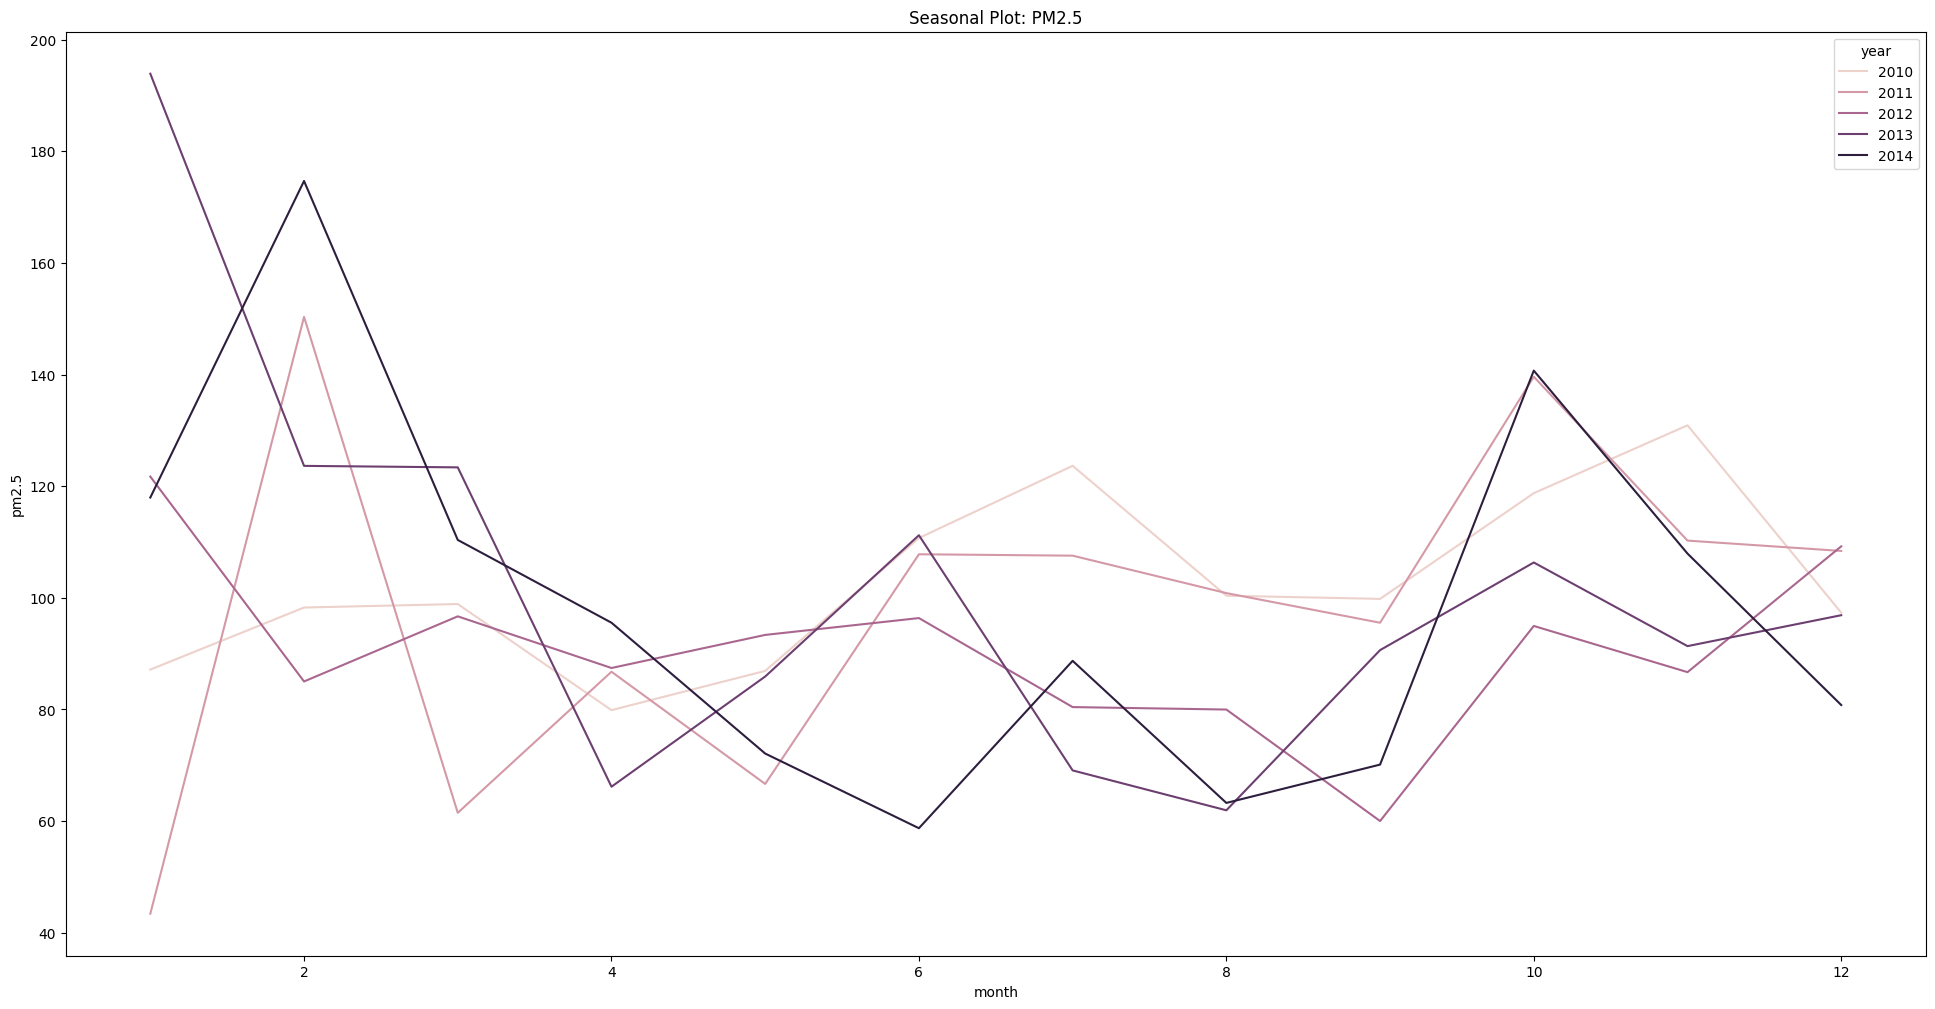

In [39]:
# Seasonal Plot: No pattern
df_monthly['month'] = df_monthly.index.month
df_monthly['year'] = df_monthly.index.year
plt.figure(figsize=(24, 12))
sns.lineplot(x='month', y='pm2.5', hue='year', data=df_monthly)
plt.title('Seasonal Plot: PM2.5')
plt.show()

In [65]:
# Dropping ['No', 'year', 'month', 'day', 'hour', 'dateString'] columns
colsToDrop = ['year', 'month', 'day', 'hour']
df_daily.drop(colsToDrop, axis=1, inplace=True, errors='ignore')
df_daily.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
Date,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,55.43,4,0
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,127.84,27,0
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,198.45,0,0
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,218.57,0,0
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,59.00,0,0


* lws and DEWP are the variables more correlated with the output
* TEMP and DEWP are highly correlated, the weather variables are highly correlated to each other [DEWP, TEMP, PRES]

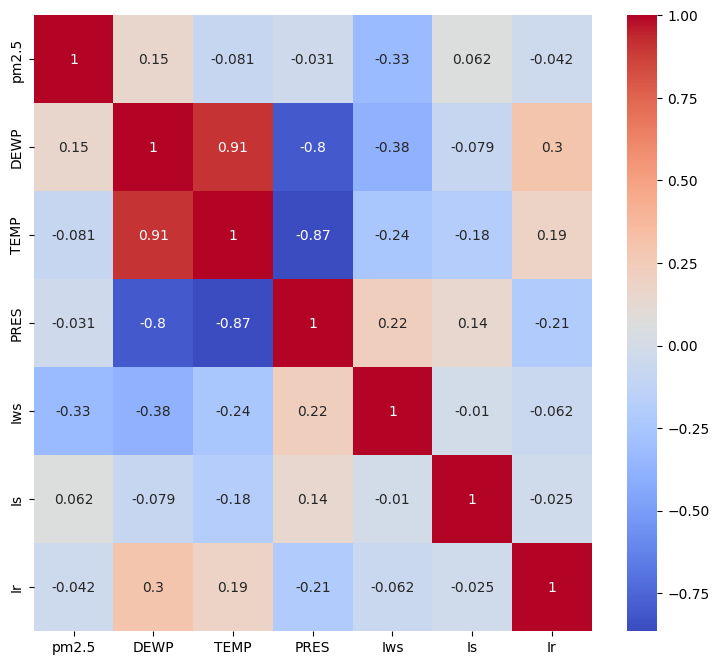

In [66]:
# Create correlation matrix
corr_matrix = df_daily.corr()

plt.figure(figsize=(9,8))
sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Variables like DEWP, TEMP and PRES do appear to show seasonality each year which makes sense given they are all weather related so they will repeat as the seasons do

In [67]:
# Analyzing all variables time series
def allTimeSeries(df_daily):
      # Create a plot with multiple traces
      fig = go.Figure()

      # Add traces
      for col in df_daily.columns.tolist():
            fig.add_trace(go.Scatter(x=df_daily.index, y=df_daily[col], name=col))

      # Update the layout with the title and axis labels
      fig.update_layout(title='All variables time series', xaxis_title='Time', yaxis_title='Value')

      # Create a dropdown menu to select which traces to show

      buttons=[dict(label='All',
                  method='update',
                  args=[{'visible': [True] * 5},
                        {'title': 'Time series', 'yaxis_title': 'Value'}])]

      for name, i in zip(df_daily.select_dtypes(include=['int64','float64']).columns.tolist(), range(7)):
            mask = [False] * 7
            mask[i] = True
            buttons.append(dict(label=name,
                              method='update',
                              args=[{'visible': mask},
                                    {'title': f'{name} Time series', 'yaxis_title': 'Value'}]))

            fig.update_layout(updatemenus=[dict(type='buttons', direction='down', showactive=True, buttons=buttons)])


      # Show the plot
      fig.show()

allTimeSeries(df_daily)

Analyzing univariate outliers

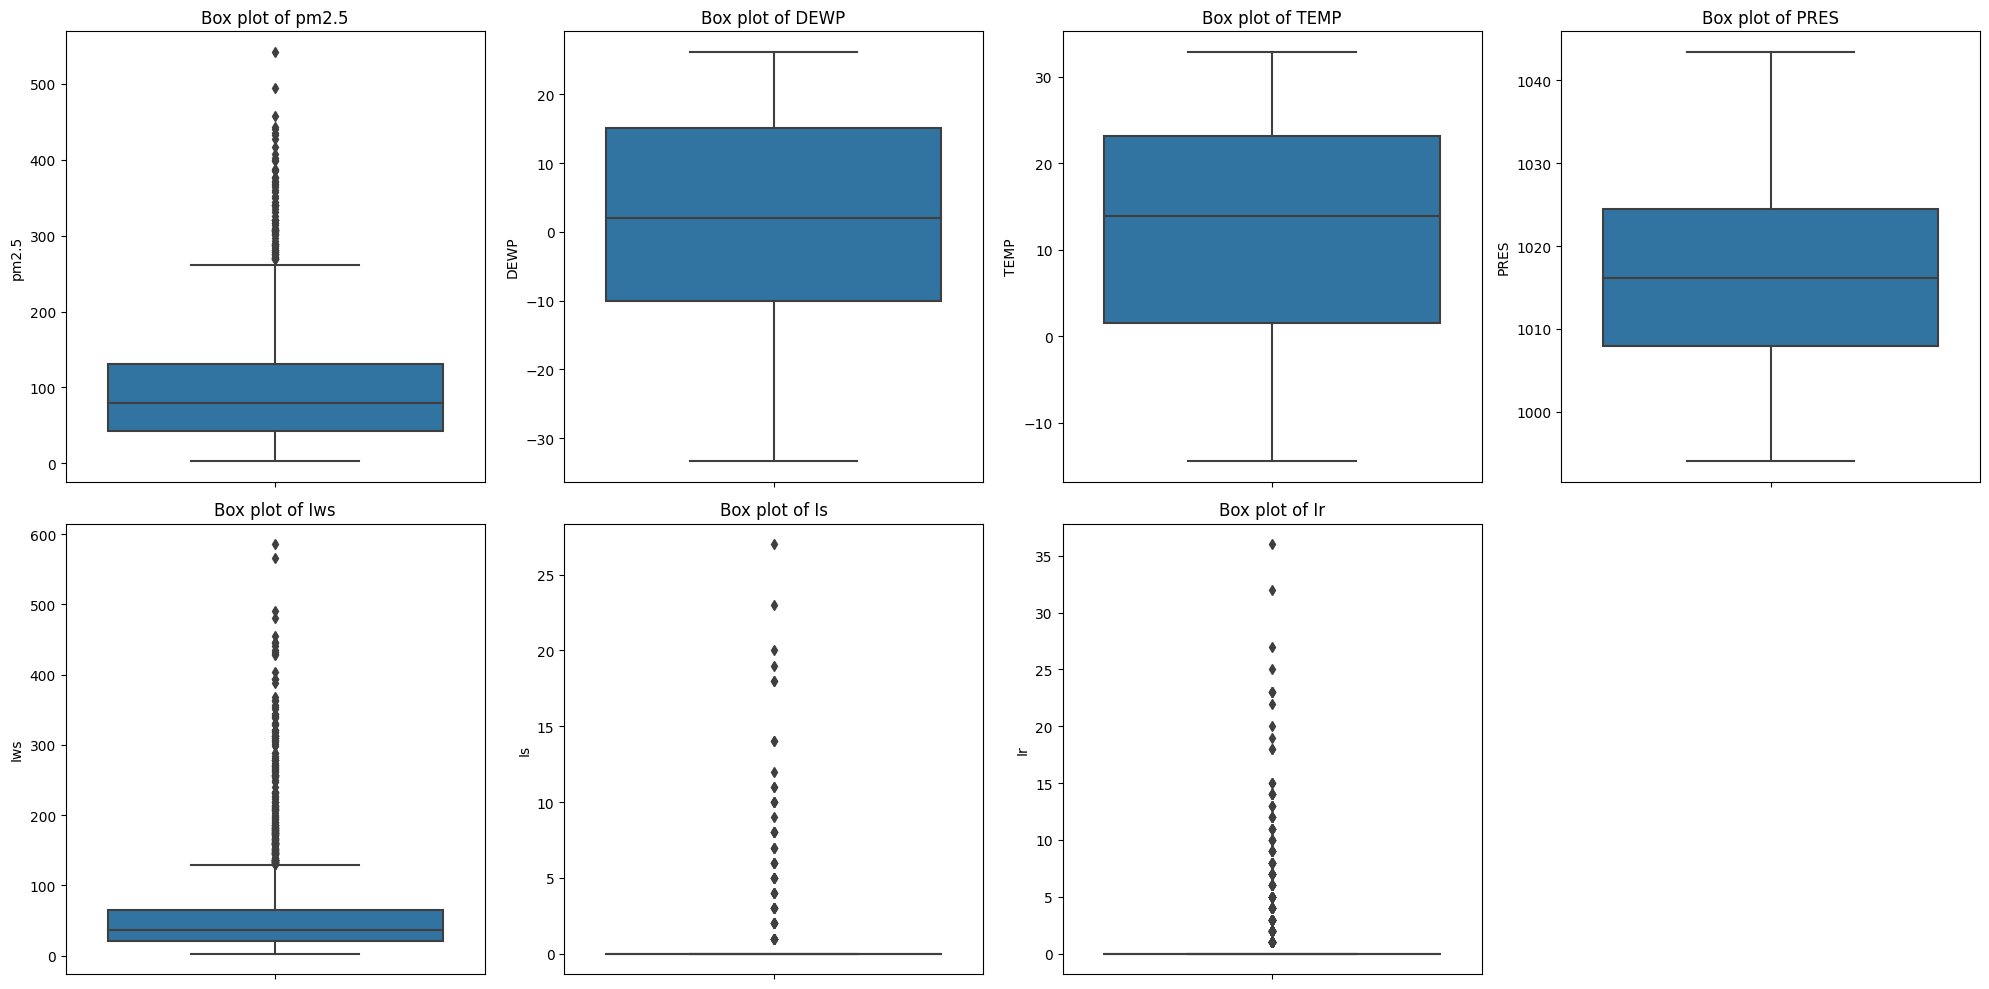

In [69]:
# Create a new figure
plt.figure(figsize=(20,10))

# Loop through each column in the dataframe
for i, column in enumerate(df_daily.columns, 1):
    # Create a new subplot for each column
    plt.subplot(2, 4, i)
    # Create a boxplot for this column
    sns.boxplot(y=df_daily[column])
    # Add a title to this subplot
    plt.title(f'Box plot of {column}')

# Show the figure with all boxplots
plt.tight_layout()
plt.show()

No clear seasonality on a monthly spectrum

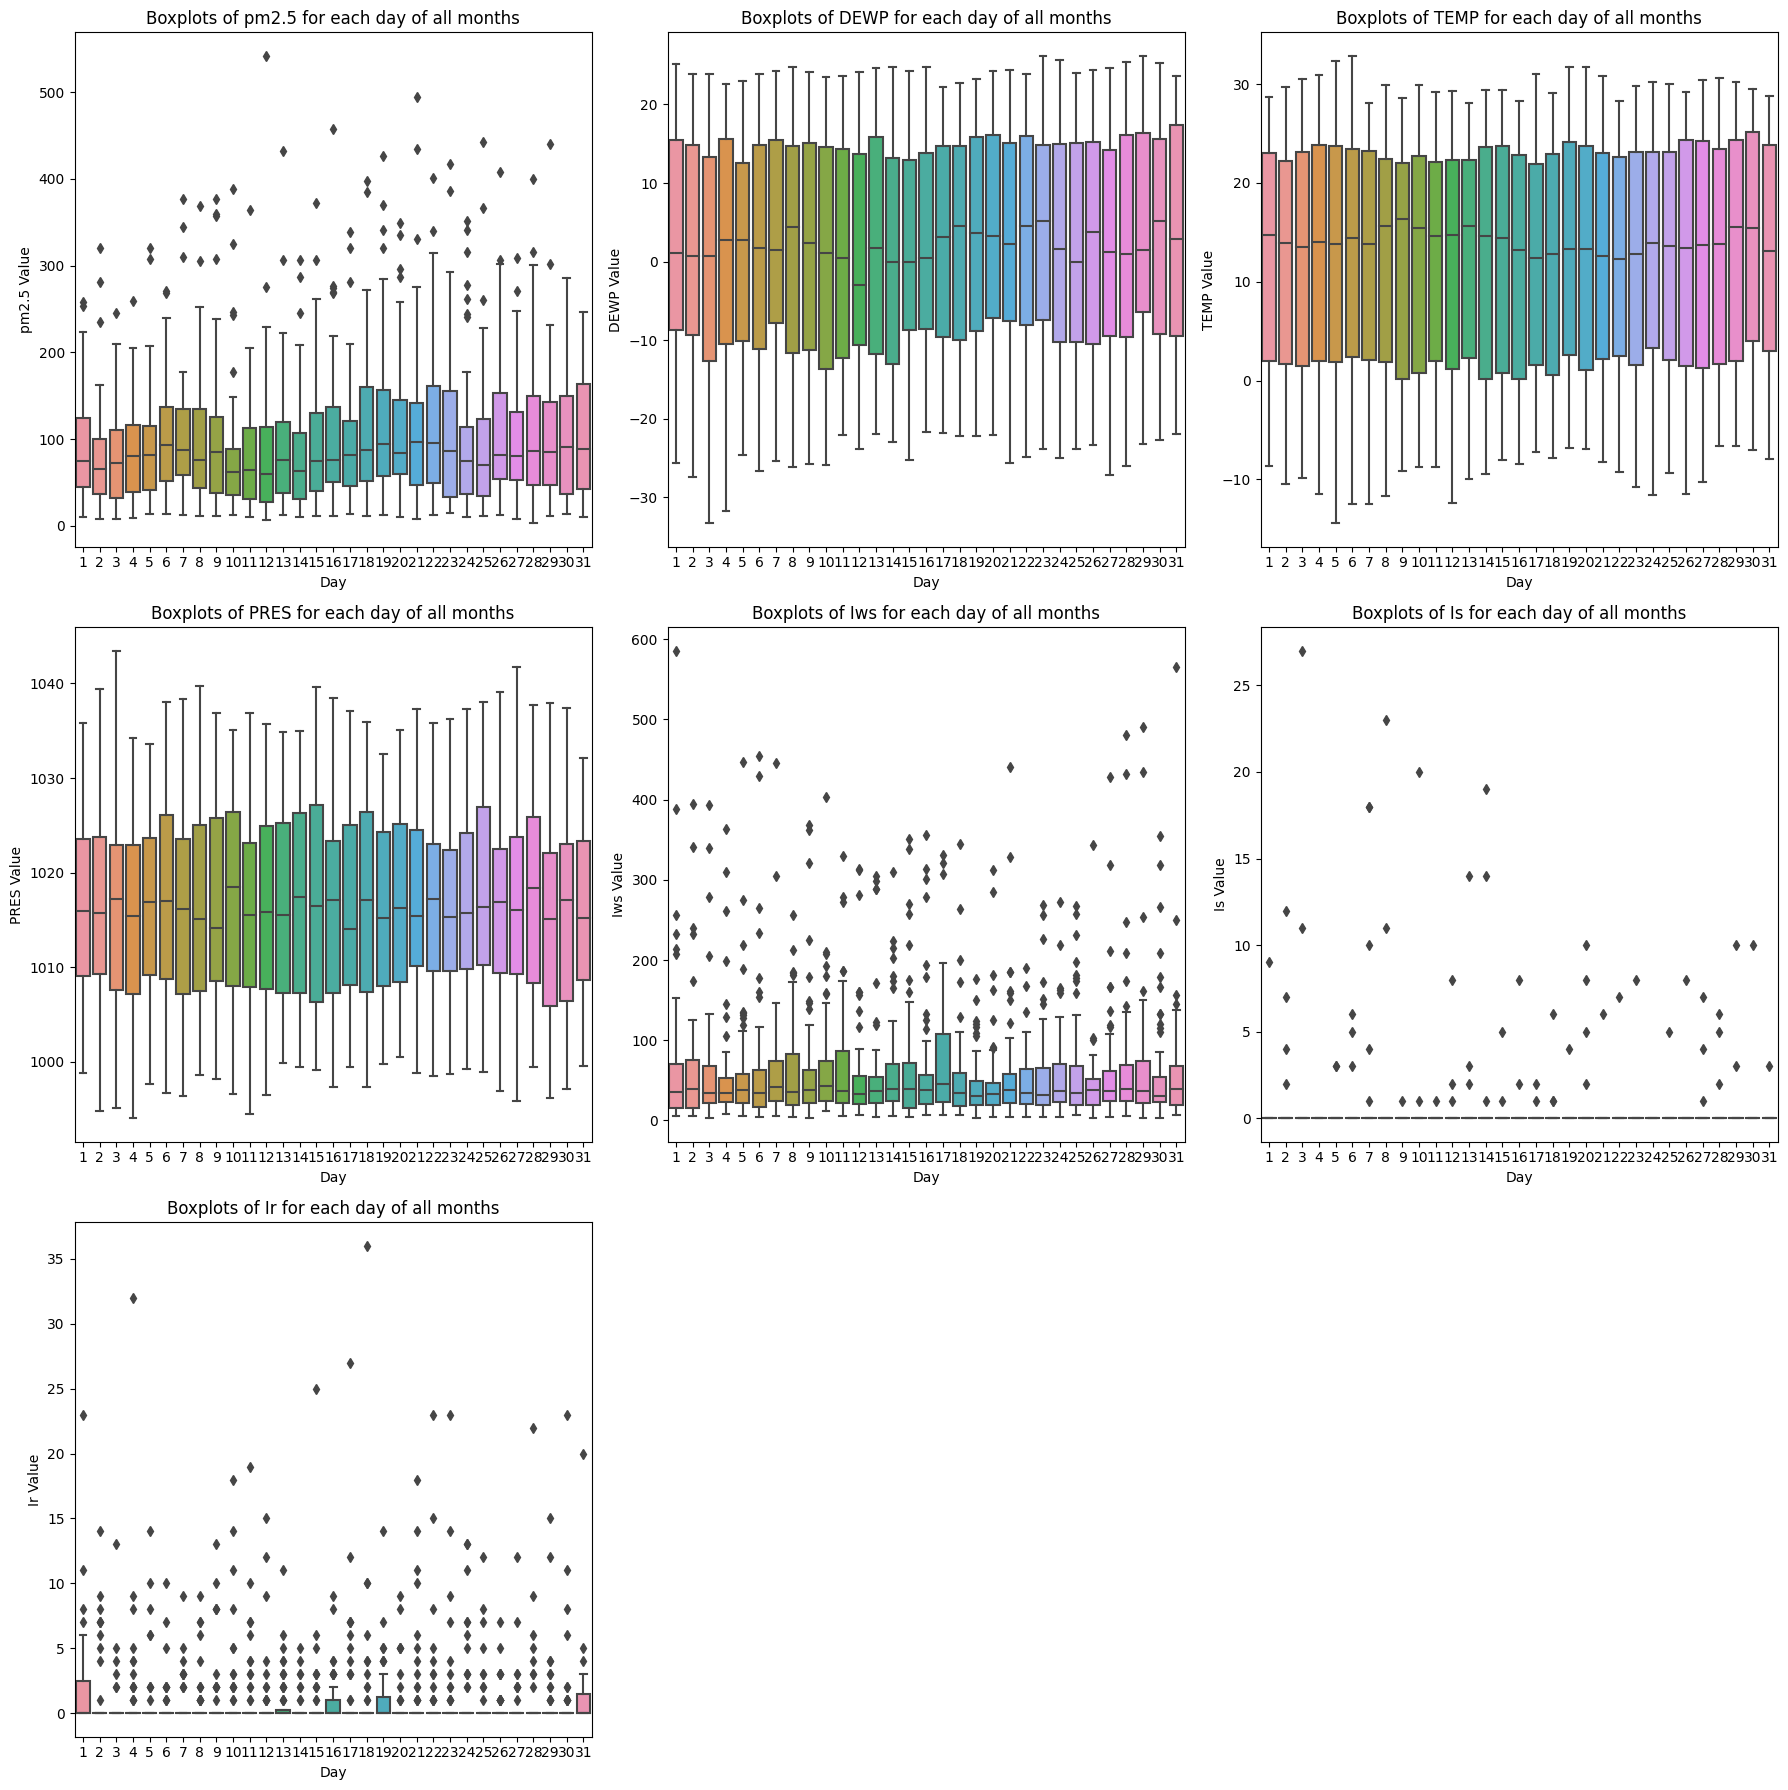

In [70]:
df_daily['day'] = df_daily.index.day
variables = df_daily.columns.tolist()[:-1]

# Create a subplot grid
fig, axs = plt.subplots(3, 3, figsize=(18, 18))

# Flatten the axes, so you can easily iterate over them
axs = axs.flatten()

# Create a boxplot for each variable
for ax, var in zip(axs, variables):
    sns.boxplot(x='day', y=var, data=df_daily, ax=ax)
    ax.set_title(f'Boxplots of {var} for each day of all months')
    ax.set_xlabel('Day')
    ax.set_ylabel(f'{var} Value')

# Remove empty plots
for i in range(len(variables), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

We can observe the mentioned seasonality of the weather conditions on a yearly spectrum

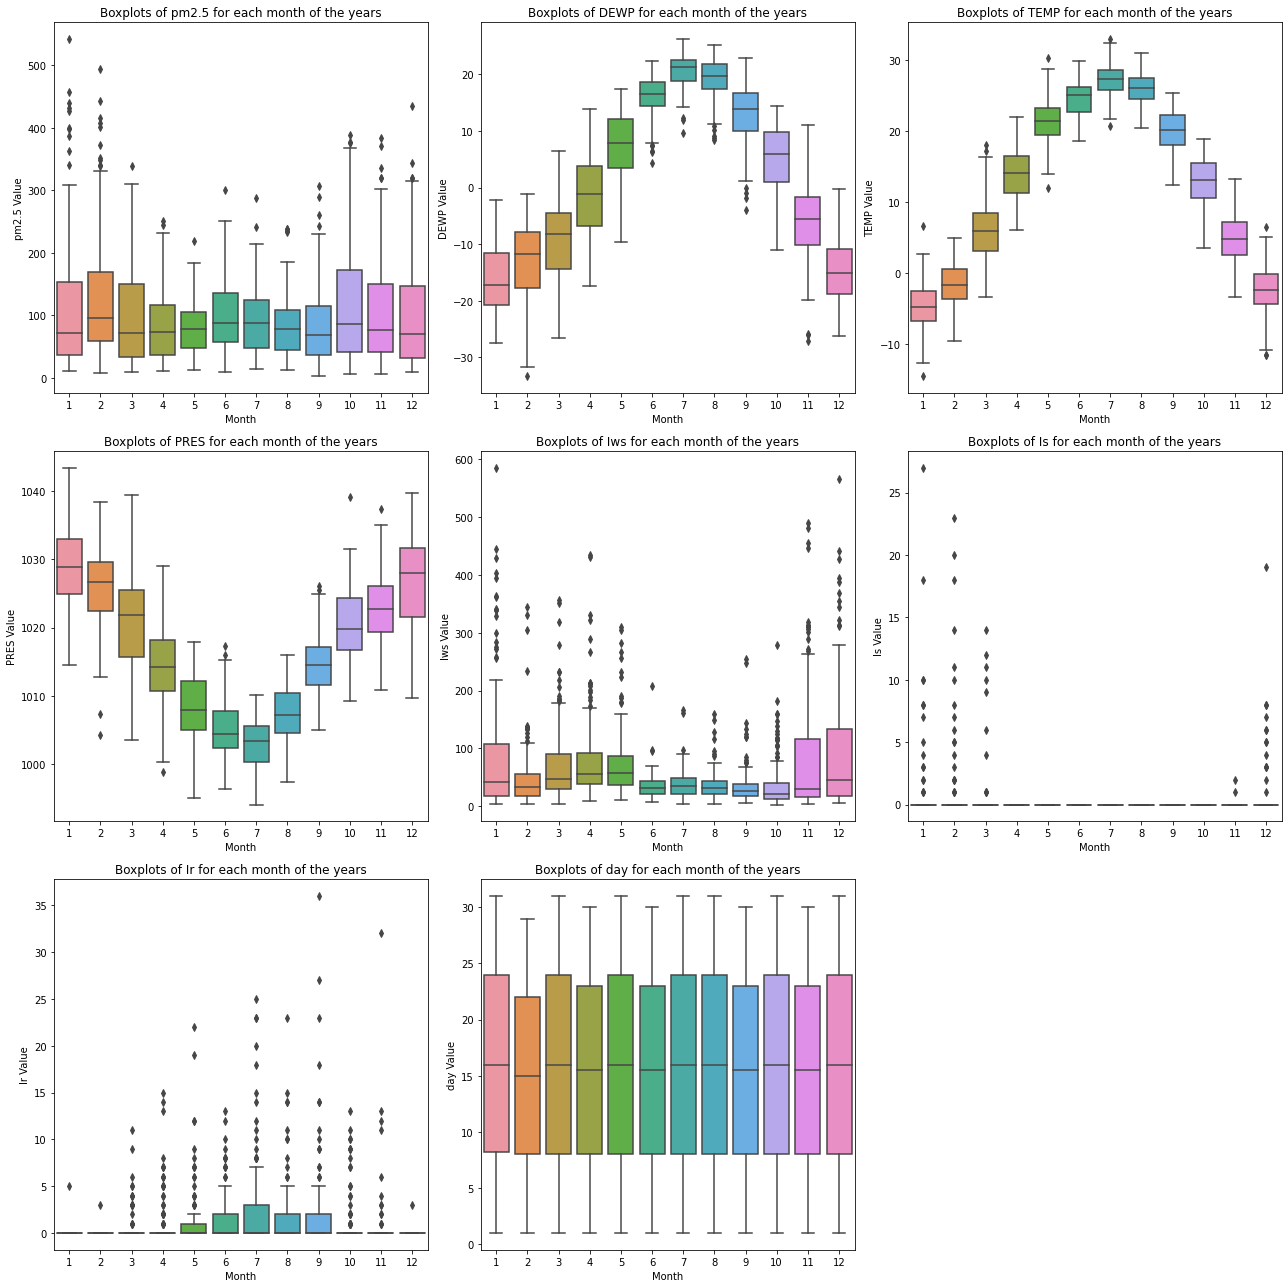

In [434]:
df_daily['month'] = df_daily.index.month
variables = df_daily.columns.tolist()[:-1]

# Create a subplot grid
fig, axs = plt.subplots(3, 3, figsize=(18, 18))

# Flatten the axes, so you can easily iterate over them
axs = axs.flatten()

# Create a boxplot for each variable
for ax, var in zip(axs, variables):
    sns.boxplot(x='month', y=var, data=df_daily, ax=ax)
    ax.set_title(f'Boxplots of {var} for each month of the years')
    ax.set_xlabel('Month')
    ax.set_ylabel(f'{var} Value')

# Remove empty plots
for i in range(len(variables), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

In [71]:
df_daily.drop(labels=['day', 'month'], axis=1, inplace=True, errors='ignore')

Lets run some tests before adancing to training

In [75]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test'):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [76]:
# Bad results in Is_x-Iws_y, Is_x-Ir_y, Ir_x-PRES_y, Ir_x-Is_y, Ir_x-Iws_y, Iws_x-Is_y this might suggest VAR could not be the most suitable technique, might want to try removing these variables
maxlag=12
test = 'ssr_chi2test'
grangers_causation_matrix(df_daily, variables = df_daily.columns)

d:\ProgramFiles\anaconda3\envs\proyecto_imagen\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

d:\ProgramFiles\anaconda3\envs\proyecto_imagen\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

d:\ProgramFiles\anaconda3\envs\proyecto_imagen\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

d:\ProgramFiles\anaconda3\envs\proyecto_imagen\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

d:\ProgramFiles\anaconda3\envs\proyecto_imagen\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

d:\ProgramFiles\anaconda3\envs\proyecto_imagen\lib\site-packages\statsmodels\tsa\stattools.py:1488: 

,pm2.5_x,DEWP_x,TEMP_x,PRES_x,Iws_x,Is_x,Ir_x
pm2.5_y,1.0000,0.0006,0.002,0.0,0.0000,0.0000,0.0000
DEWP_y,0.0000,1.0000,0.000,0.0,0.0000,0.0000,0.0000
TEMP_y,0.0000,0.0000,1.000,0.0,0.0000,0.0174,0.0000
PRES_y,0.0000,0.0000,0.000,1.0,0.0000,0.0003,0.3597
Iws_y,0.0234,0.0000,0.000,0.0,1.0000,0.0548,0.1186
Is_y,0.0014,0.0000,0.000,0.0,0.0582,1.0000,0.2741
Ir_y,0.0000,0.0000,0.000,0.0,0.0033,0.0964,1.0000


In [91]:
def adjust(val, length= 6): return str(val).ljust(length)

In [90]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [89]:
# Lets remove precipitation variables for VAR Is and Ir
cointegration_test(df_daily)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
pm2.5  ::  570.9     > 60.0627   =>   True
DEWP   ::  317.88    > 40.1749   =>   True
TEMP   ::  128.59    > 24.2761   =>   True
PRES   ::  6.18      > 12.3212   =>   False
Iws    ::  0.01      > 4.1296    =>   False


## Training

### PreProcessing for VAR

In [79]:
cols_to_remove = ['day', 'month', 'Is', 'Ir']
n_obs = 100
df_daily.drop(labels=cols_to_remove, axis=1, inplace=True, errors='ignore')
df_train, df_test = df_daily[:-n_obs], df_daily[-n_obs:]

#### Stationarity

DEWP and TEMP have a p-value greater than 0.05 so its clear they are not stationary, PRES has a 0.027 p-value which is ok but close to reaching 0.05. Lets difference

In [80]:
def check_stationarity(timeseries, signif=0.05):
    result = adfuller(timeseries)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(' ADF Statistic: %f' % result[0])
    print(' p-value: %f' % result[1])
    print(f' No. Lags Chosen = {result[2]}')

In [81]:
# We need to difference two variables are not stationary
for column in df_train.columns:
    print(f"\nADF test for {column}")
    print('-'*50)
    check_stationarity(df_train[column])


ADF test for pm2.5
--------------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 ADF Statistic: -22.096415
 p-value: 0.000000
 No. Lags Chosen = 1

ADF test for DEWP
--------------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 ADF Statistic: -2.252160
 p-value: 0.187862
 No. Lags Chosen = 11

ADF test for TEMP
--------------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 ADF Statistic: -2.493497
 p-value: 0.117065
 No. Lags Chosen = 23

ADF test for PRES
--------------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 ADF Statistic: -3.135200
 p-value: 0.024056
 No. Lags Chosen = 13

ADF test for Iws
--------------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stat

In [82]:
#After difference it looks okay
df_differenced = df_train.diff().dropna()

# Call the function for each variable
for column in df_differenced.columns:
    print(f"\nADF test for {column}")
    print('-'*50)
    check_stationarity(df_differenced[column])


ADF test for pm2.5
--------------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 ADF Statistic: -13.611332
 p-value: 0.000000
 No. Lags Chosen = 23

ADF test for DEWP
--------------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 ADF Statistic: -19.808174
 p-value: 0.000000
 No. Lags Chosen = 10

ADF test for TEMP
--------------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 ADF Statistic: -19.245530
 p-value: 0.000000
 No. Lags Chosen = 7

ADF test for PRES
--------------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 ADF Statistic: -14.040183
 p-value: 0.000000
 No. Lags Chosen = 17

ADF test for Iws
--------------------------------------------------
 Null Hypothesis: Data has unit root. Non-S

In [83]:
def plotACF_PACF(df_daily, col, lag=35):
   # ACF - PACF
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # ACF plot
    plot_acf(df_daily[col], ax=ax1, lags=lag)
    ax1.set_title('Autocorrelation Function (ACF)')

    # PACF plot
    plot_pacf(df_daily[col], ax=ax2, lags=lag)
    ax2.set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

### VAR

In [127]:
scale = MinMaxScaler()
df_differenced = scale.fit_transform(df_differenced)

In [128]:
model = VAR(df_differenced)
max_order = 20
for i in range(max_order + 1)[1:]:
    result = model.fit(i)
    print(f'Lag Order = {i}')
    print(f'AIC : {result.aic}')
    print(f'BIC : {result.bic}')
    print(f'FPE : {result.fpe}')
    print(f'HQIC: {result.hqic}\n')
    print('---'*20)

Lag Order = 1
AIC : -23.017066552254025
BIC : -22.922142195262825
FPE : 1.0088232155576163e-10
HQIC: -22.981949015469695

------------------------------------------------------------
Lag Order = 2
AIC : -23.248325260929146
BIC : -23.074214754149633
FPE : 8.005362510254787e-11
HQIC: -23.18391069900159

------------------------------------------------------------
Lag Order = 3
AIC : -23.418088506832902
BIC : -23.164716709217025
FPE : 6.75545410903085e-11
HQIC: -23.324347405060802

------------------------------------------------------------
Lag Order = 4
AIC : -23.509180338234323
BIC : -23.17647199240305
FPE : 6.167303768716928e-11
HQIC: -23.38608313492179

------------------------------------------------------------
Lag Order = 5
AIC : -23.55947527108507
BIC : -23.14735500308055
FPE : 5.864822909549926e-11
HQIC: -23.406992357439762

------------------------------------------------------------
Lag Order = 6
AIC : -23.61312506399573
BIC : -23.12151738303278
FPE : 5.5585125553089886e-11
HQ

In [129]:
order = 1
model_fitted = model.fit(order)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 19, Jun, 2023
Time:                     11:00:16
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -22.9221
Nobs:                     1723.00    HQIC:                  -22.9819
Log likelihood:           7635.05    FPE:                1.00882e-10
AIC:                     -23.0171    Det(Omega_mle):     9.91440e-11
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.696240         0.037028           18.803           0.000
L1.y1        -0.075684         0.031742           -2.384           0.017
L1.y2        -0.000539         0.026364           -0.020           0.984
L1.y3        -0.004990

In [130]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_daily.columns, out):
    print(adjust(col), ':', round(val, 2))

pm2.5  : 2.07
DEWP   : 2.07
TEMP   : 2.05
PRES   : 1.99
Iws    : 2.08


In [131]:
# forecasting
n_forecast = 100  # forecasting the next 100 steps
forecast_input = df_differenced[-model_fitted.k_ar:]  # using the last 'order' number of data points as input
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast)
df_forecast = pd.DataFrame(fc, index=df_daily.index[-n_forecast:], columns=df_daily.columns + '_1d')

In [132]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    df_fc[columns + '_1d'] = scale.inverse_transform(df_fc[columns + '_1d'])
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [133]:
df_results = invert_transformation(df_train, df_forecast)        
df_results

,pm2.5_1d,DEWP_1d,TEMP_1d,PRES_1d,Iws_1d,pm2.5_forecast,DEWP_forecast,TEMP_forecast,PRES_forecast,Iws_forecast
Date,,,,,,,,,,
2014-09-23,0.040655,0.014903,0.051027,-0.056504,-0.057400,106.915655,17.056570,20.217693,1018.276829,33.042600
2014-09-24,-0.003028,0.003858,0.014812,-0.003348,0.014524,106.912627,17.060428,20.232505,1018.273482,33.057124
2014-09-25,-0.001926,-0.001917,-0.002109,0.003299,-0.002120,106.910700,17.058511,20.230396,1018.276781,33.055004
2014-09-26,0.001556,0.001087,0.000415,-0.000112,-0.000896,106.912256,17.059598,20.230811,1018.276670,33.054108
2014-09-27,0.000574,0.000500,0.001281,0.000076,-0.000554,106.912830,17.060098,20.232092,1018.276746,33.053554
...,...,...,...,...,...,...,...,...,...,...
2014-12-27,0.000650,0.000528,0.000945,0.000199,-0.000639,106.971925,17.108159,20.318022,1018.294930,32.995395
2014-12-28,0.000650,0.000528,0.000945,0.000199,-0.000639,106.972575,17.108688,20.318967,1018.295130,32.994756
2014-12-29,0.000650,0.000528,0.000945,0.000199,-0.000639,106.973225,17.109216,20.319912,1018.295329,32.994117


The RMSE results are quite dismal, this might indicate we are missing some important preprocessing or that VAR is just not potent enough nor fit for this problem

In [134]:
rmse = np.mean((df_results['pm2.5_forecast'] - df_test['pm2.5'])**2)**.5
print(f'RMSE: {rmse}')

RMSE: 92.53237301510103


### LSTM

In [385]:
# Lets load the data again since we are going to apply a different preprocessing, we will onl drop the first nan values and fill the rest of nan with zeros
file_path = os.path.join(os.getcwd(), '../data/us_ambassy/PRSA_data_2010.1.1-2014.12.31.csv')
df = pd.read_csv(file_path)

# Dropping
df = df[24:]
df['pm2.5'].fillna(0, inplace=True)

df['dateInt']=df['year'].astype(str) + df['month'].astype(str).str.zfill(2)+ df['day'].astype(str).str.zfill(2)+df['hour'].astype(str).str.zfill(2)
df['Date'] = pd.to_datetime(df['dateInt'], format='%Y%m%d%H')
df.set_index('Date', inplace=True)

# encoder = LabelEncoder()
# df['cbwd'] = encoder.fit_transform(df['cbwd'])

df.drop(labels=['No','year', 'month', 'day', 'hour', 'Date', 'dateInt'], axis=1, inplace=True, errors='ignore')
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
Date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [386]:
# Daily Averages and Max of the cumulative
cumulative_cols = ['Iws', 'Is', 'Ir']

# Calculating daily averages
df_daily = df.drop(cumulative_cols + ['cbwd'], axis=1).resample('D').mean()

# Resample the cumulative columns to daily frequency, aggregating with max
df_daily_cumulative = df[cumulative_cols].resample('D').max()

# Combine the two dataframes
df_daily = pd.concat([df_daily, df_daily_cumulative], axis=1).dropna()

In [387]:
# FUNCTION FROM INTERNET: convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [389]:
def colsToDrop(n_out, n_features):
    all_drop = [-x for x in range(1,n_features+1)]
    drop = all_drop
    for i in range(n_out-1):
        drop = [x - n_features for x in drop]
        all_drop += drop
    return all_drop 

In [421]:
dataset = df_daily
values_org = dataset.values
# ensure all data is float
values_org = values_org.astype('float32')
# normalize features
scaler = StandardScaler() #feature_range=(0, 1)
scaled = scaler.fit_transform(values_org)

# create a MinMaxScaler for the pm2.5 data
pm25_scaler = StandardScaler()

# fit and transform the pm2.5 data
pm25_scaled = pm25_scaler.fit_transform(values_org[:, 0].reshape(-1, 1))

# replace the pm2.5 data in the 'values' array with the scaled pm2.5 data
scaled[:, 0] = pm25_scaled.ravel()

# frame as supervised learning
n_days=300
n_out = 100 # 100
n_features=7
reframed = series_to_supervised(scaled, n_days, n_out)
# drop columns we don't want to predict
reframed.drop(reframed.columns[colsToDrop(n_out=n_out, n_features=n_features)], axis=1, inplace=True)
print(reframed.head())
print(reframed.columns)

     var1(t-300)  var2(t-300)  var3(t-300)  var4(t-300)  var5(t-300)  \
300     0.671886    -0.729434    -1.522450     0.824228    -0.063807   
301    -0.196350    -0.844197    -1.818270     0.629822     0.952478   
302    -0.810744    -1.603398    -2.074406     1.275086     1.943499   
303    -0.666847    -1.865293    -2.330543     1.705271     2.225886   
304    -0.486301    -1.803497    -2.164595     1.717680    -0.013701   

     var6(t-300)  var7(t-300)  var1(t-299)  var2(t-299)  var3(t-299)  ...  \
300     2.346997    -0.327777    -0.196350    -0.844197    -1.818270  ...   
301    16.634914    -0.327777    -0.810744    -1.603398    -2.074406  ...   
302    -0.137858    -0.327777    -0.666847    -1.865293    -2.330543  ...   
303    -0.137858    -0.327777    -0.486301    -1.803497    -2.164595  ...   
304    -0.137858    -0.327777    -0.323540    -1.629882    -2.160987  ...   

     var5(t-2)  var6(t-2)  var7(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  \
300  -0.659879  -0.137858  -0.3

In [413]:
reframed.values.shape

(1626, 700)

In [423]:
# split into train and test sets
values = reframed.values
n_train_days = 1000 # 1200
train = values[:n_train_days, :]
validation = values[n_train_days:-100, :]
test = values[-100:, :]

# split into input and outputs
n_obs = n_days * n_features
X_train, y_train = train[:, :n_obs], train[:, -n_out:]
X_validation, y_validation = validation[:, :n_obs], validation[:, -n_out:]
X_test, y_test = test[:, :n_obs], test[:, -n_out:]

In [424]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_days, n_features))
X_validation = X_validation.reshape((X_validation.shape[0], n_days, n_features))
X_test = X_test.reshape((X_test.shape[0], n_days, n_features))
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)

(1000, 300, 7) (1000, 100) (326, 300, 7) (326, 100) (100, 300, 7) (100, 100)


In [425]:
OPTIMIZER = Adam(learning_rate=0.01)
model = Sequential()
model.add(LSTM(72, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(100))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(n_out))
model.compile(loss='mse', optimizer=OPTIMIZER)

Model overfits a little bit, could be downscaled

Epoch 1/10


4/4 - 11s - loss: 1.3190 - val_loss: 0.6720 - 11s/epoch - 3s/step
Epoch 2/10
4/4 - 8s - loss: 0.7939 - val_loss: 0.6784 - 8s/epoch - 2s/step
Epoch 3/10
4/4 - 8s - loss: 0.6972 - val_loss: 0.6251 - 8s/epoch - 2s/step
Epoch 4/10
4/4 - 8s - loss: 0.6450 - val_loss: 0.6094 - 8s/epoch - 2s/step
Epoch 5/10
4/4 - 8s - loss: 0.6119 - val_loss: 0.6023 - 8s/epoch - 2s/step
Epoch 6/10
4/4 - 8s - loss: 0.5808 - val_loss: 0.5952 - 8s/epoch - 2s/step
Epoch 7/10
4/4 - 8s - loss: 0.5612 - val_loss: 0.5737 - 8s/epoch - 2s/step
Epoch 8/10
4/4 - 8s - loss: 0.5484 - val_loss: 0.5703 - 8s/epoch - 2s/step
Epoch 9/10
4/4 - 8s - loss: 0.5303 - val_loss: 0.5681 - 8s/epoch - 2s/step
Epoch 10/10
4/4 - 9s - loss: 0.5179 - val_loss: 0.5611 - 9s/epoch - 2s/step


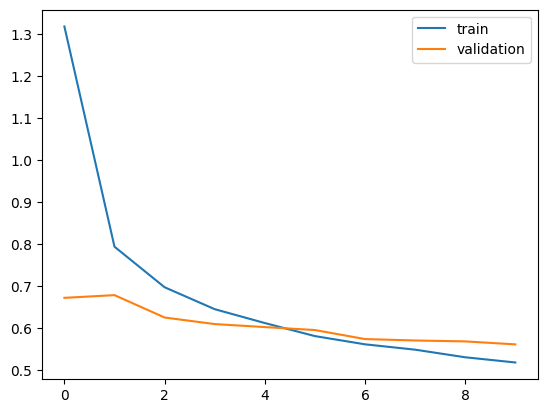

In [426]:
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_validation, y_validation), verbose=2, shuffle=True)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

Results are far better than the VAR model however, there is still much room for improvement, the model could benefit greatly from some more preprocessing of the data

In [427]:
# Predict and invert scaling
yhat = model.predict(X_test[0].reshape((1, n_days, n_features)))
inv_yhat = pm25_scaler.inverse_transform(yhat)

inv_pm25_real = pm25_scaler.inverse_transform(y_test[0].reshape(-1, 1))

# Calculate RMSE
predictions = inv_yhat[0].reshape(1,100)
actuals = inv_pm25_real.reshape(1,100)

rmse = sqrt(mean_squared_error(actuals, predictions))
print('Test RMSE: %.3f' % rmse)

1/1 [==============================] - 0s 475ms/step
Test RMSE: 38.810
